In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import ttest_ind as ttest
from colorama import Fore
import math

## Missing Data Analysis

In [2]:
original=pd.read_csv('/Users/omarhassan/Documents/GitHub/BigMart-Analysis/Dataset/data.csv') #Original Dataset with missing values 
data=original #Both data and original refer to the same address
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Data Cleaning

In [3]:
for col in data.drop(['Item_Identifier','Outlet_Identifier'],axis=1).columns:
    if(type(data[col][0])==str):
        print(col)
        print(data[col].value_counts())

Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64
Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64
Outlet_Type
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64


The code above checks for the unique values that are stored in each variables. On analysing this it is seen that the variable Item_Fat_Content has a few typos that refer to the same thing: LF=low fat=Low Fat and reg=Regular. The other categorical variables are free of this kind of errors. To fix this we first convert all the values stored in Item_Fat_Content to capital letters to avoid case sensitive typos and errors and then we replace 'LOW FAT' by 'LF' to avoid the complications in code cause by the space between 'LOW FAT' and replace 'REG' with 'REGULAR'. 

In [4]:
for i in range(len(data['Item_Fat_Content'])):
    data.loc[i,'Item_Fat_Content']=data['Item_Fat_Content'][i].upper()
    if(data.loc[i,'Item_Fat_Content']=='REG'):
        data.loc[i,'Item_Fat_Content']='REGULAR'
    elif(data.loc[i,'Item_Fat_Content']=='LOW FAT'):
        data.loc[i,'Item_Fat_Content']='LF'

In [5]:
data['Item_Fat_Content'].value_counts() #To check if the variable is cleaned

LF         9185
REGULAR    5019
Name: Item_Fat_Content, dtype: int64

In [6]:
data.info() #used to study the datatypes used to store the variables and the number of non-null values available 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          14204 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [7]:
data.isnull().sum() #Calculates the Null Values present in each variable

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### 17% Missing from item_weight  
#### 28% missing for outlet size

Since the amount of missing values are large we will perform the following test to analyse the randomness of the missing data.

<Axes: >

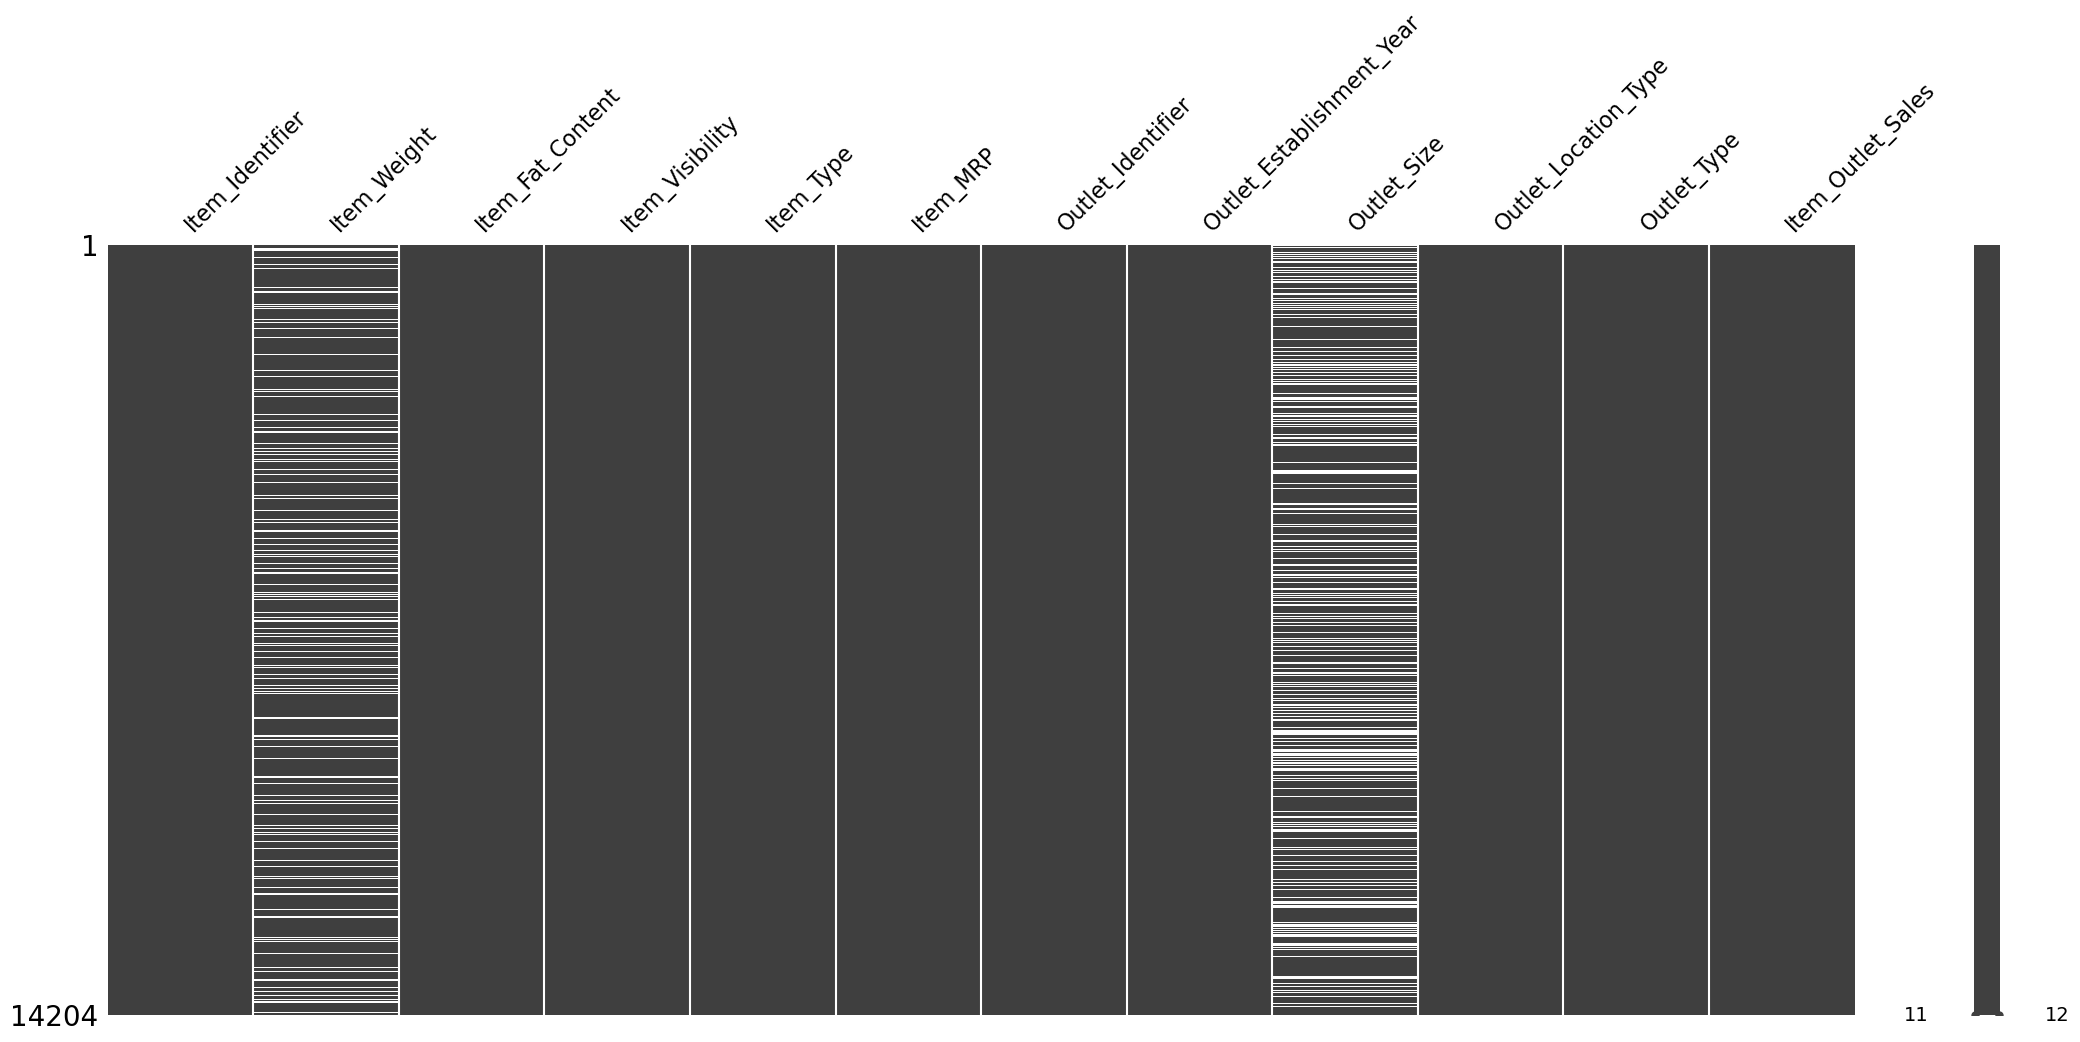

In [8]:
msno.matrix(data) #Represents missing data as a white line

<Axes: >

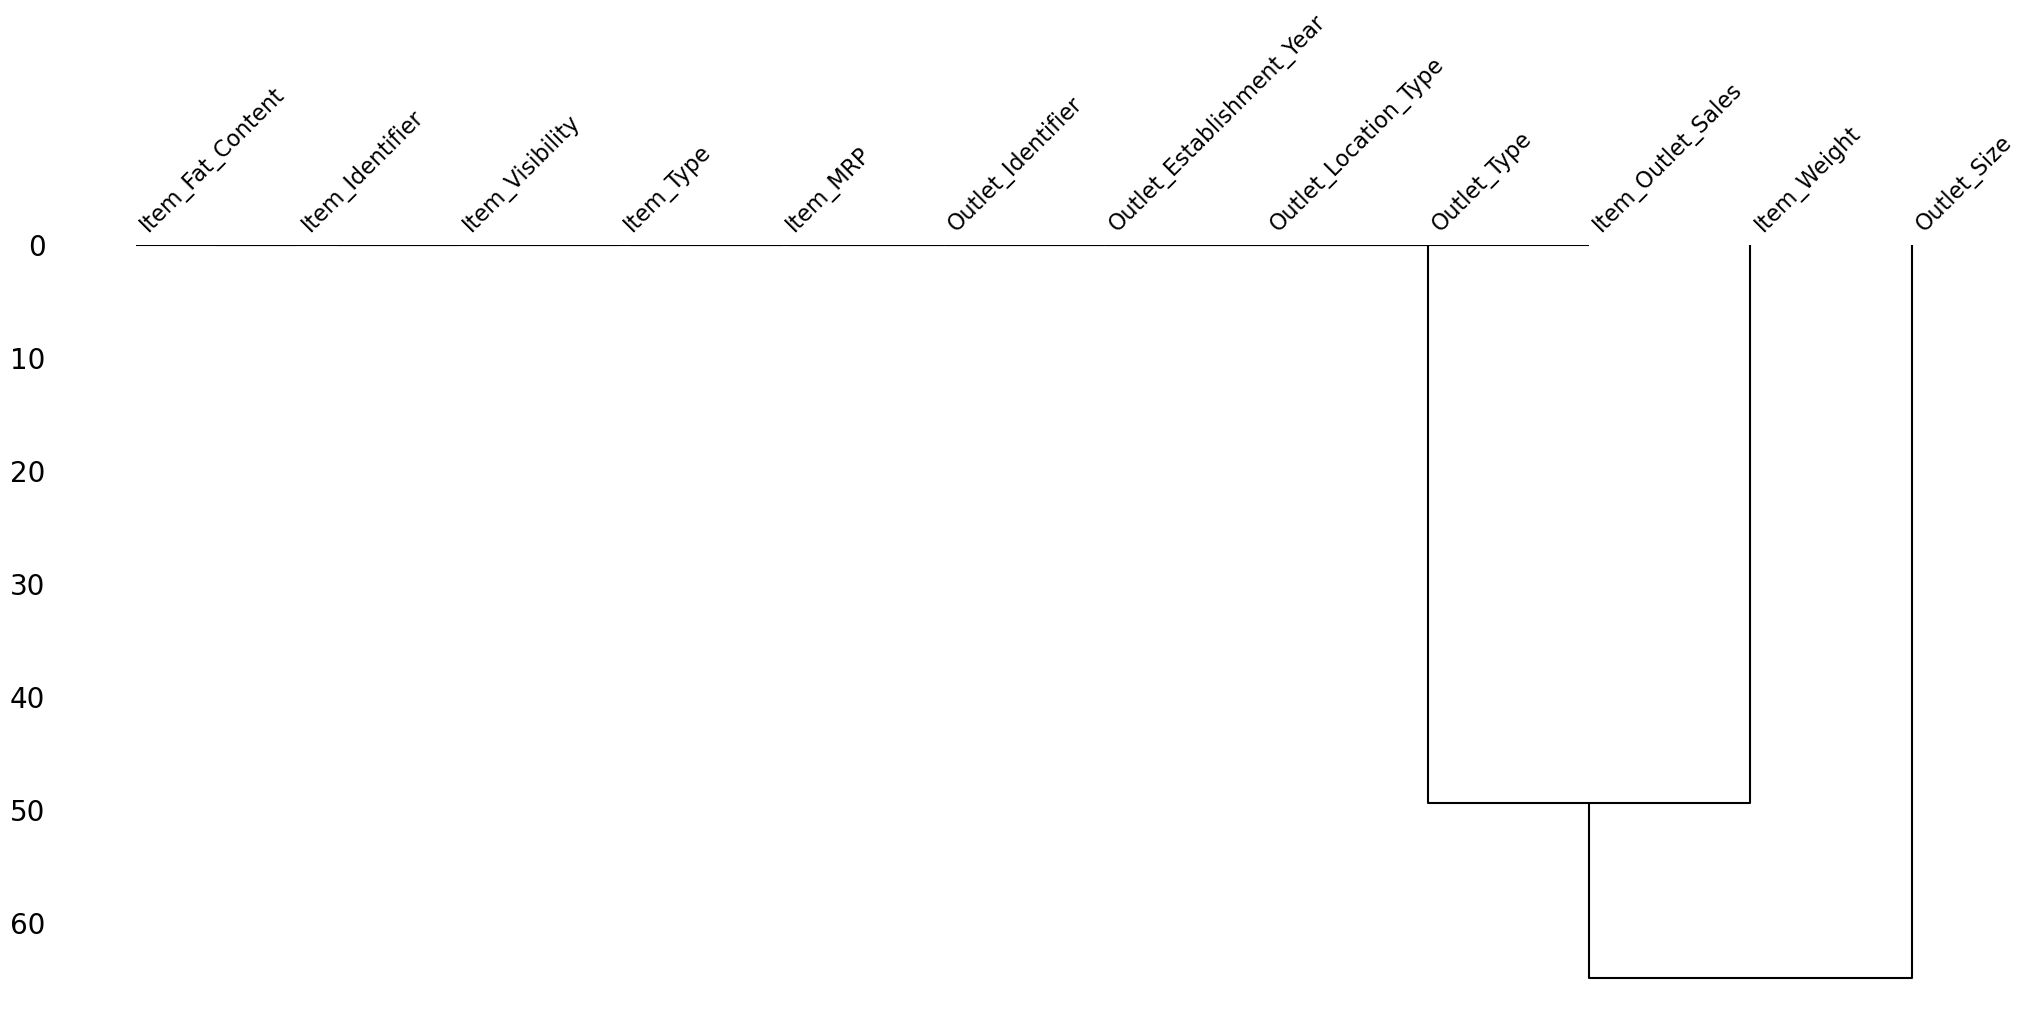

In [9]:
msno.dendrogram(data) #Connects possible factors for missing values using dendrograms

Since the graphs aren't exactly clear on the randomness of the missing data. We perform a more detailed analysis to find out if the data is MAR (Missing At Random) or MCAR(Missing Completely At Random).

In [10]:
group1=data[data['Item_Weight'].isnull()] #Groups rows with missing Item_Weight values
group2=data[data['Item_Weight'].notnull()] #Groups rows with non-missing Item_Weight values

In [11]:
mcolumns=[] 
for col in data.columns: #Loop can be used to find columns with missing values and to make a list of these columns
    if(data[col].isnull().sum()>0):
        mcolumns.append(col)
mcolumns

['Item_Weight', 'Outlet_Size']

This is a user-defined function that performs comparisons among pairs of variables of the two groups of data against the missing variable to see if there is a correlation of any form to the missing data.

In [12]:
def missing_stats(data,grp1,grp2,mcol):
    for col in data.columns:
        missing=pd.DataFrame()
        if col not in mcol:
            print(Fore.BLUE+'{}'.format(col)+Fore.RESET)
            if(type(data[col].iloc[0])==str):
                missing['Group-1']=grp1[col].value_counts()
                tot1=grp1[col].value_counts().sum()
                missing['Group-2']=grp2[col].value_counts()
                tot2=grp2[col].value_counts().sum()
                missing['Group-1-proportion']=(missing['Group-1']/tot1)*100
                missing['Group-2-proportion']=(missing['Group-2']/tot2)*100
                print(missing)
                missing=missing.drop(missing.columns,axis=1,inplace=True)
            else:
                print("NUMERICAL-NUMERICAL COMPARISON")
                print('Missing {} VS {}'.format(col,col))
                tstat,pvalue=ttest(grp1[col],grp2[col])
                print('T-Test Statistic: {:.5f}'.format(tstat)+Fore.RESET)
                print('P-Value: {:.5f}'.format(pvalue))
                if(pvalue<=0.05):
                    print('they have equal means')
                else:
                    print(Fore.RED+'they do not have equal means')

In [13]:
missing_stats(data=data,grp1=group1,grp2=group2,mcol=mcolumns) #Compares missing Item_Weight to other variables

Item_Identifier
       Group-1  Group-2  Group-1-proportion  Group-2-proportion
FDP10        2        8            0.082001            0.067998
FDP27        2        8            0.082001            0.067998
FDJ33        2        8            0.082001            0.067998
FDK16        2        7            0.082001            0.059499
FDR52        2        8            0.082001            0.067998
...        ...      ...                 ...                 ...
FDX59        1        8            0.041000            0.067998
NCL29        1        7            0.041000            0.059499
FDS35        1        7            0.041000            0.059499
FDU34        1        7            0.041000            0.059499
FDN31        1        8            0.041000            0.067998

[1559 rows x 4 columns]
Item_Fat_Content
         Group-1  Group-2  Group-1-proportion  Group-2-proportion
LF          1578     7607           64.698647           64.657884
REGULAR      861     4158           35.301

/var/folders/g6/gnm6sg1x75v01cb5lyv79rr40000gn/T/ipykernel_12930/1530405411.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tstat,pvalue=ttest(grp1[col],grp2[col])


In [14]:
group3=data[data['Outlet_Size'].isnull()] #Group with Outlet_Size missing
group4=data[data['Outlet_Size'].notnull()] #Group without Outlet_Size missing

In [15]:
missing_stats(data=data,grp1=group3,grp2=group4,mcol=mcolumns)

Item_Identifier
       Group-1  Group-2  Group-1-proportion  Group-2-proportion
FDX07        3        6            0.074701            0.058893
FDX21        3        7            0.074701            0.068708
NCN41        3        7            0.074701            0.068708
FDE29        3        6            0.074701            0.058893
FDE24        3        7            0.074701            0.068708
...        ...      ...                 ...                 ...
DRB01        1        7            0.024900            0.068708
FDG21        1        7            0.024900            0.068708
FDK32        1        7            0.024900            0.068708
NCU06        1        7            0.024900            0.068708
NCT29        1        7            0.024900            0.068708

[1559 rows x 4 columns]
Item_Fat_Content
         Group-1  Group-2  Group-1-proportion  Group-2-proportion
LF          2595     6590           64.616534           64.683942
REGULAR     1421     3598           35.383

Further investigation to try and verify the statistics above

(array([258., 161., 296., 373., 237., 311., 343., 132., 165., 163.]),
 array([ 31.29   ,  54.81984,  78.34968, 101.87952, 125.40936, 148.9392 ,
        172.46904, 195.99888, 219.52872, 243.05856, 266.5884 ]),
 <BarContainer object of 10 artists>)

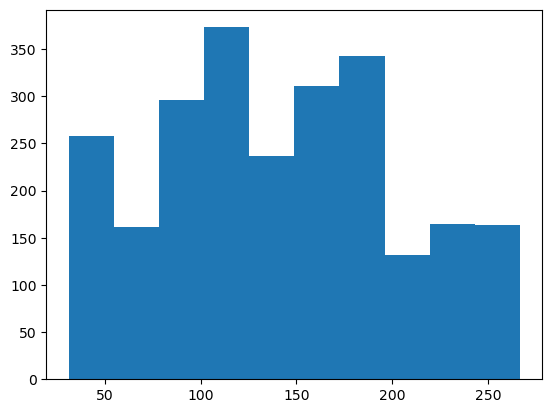

In [16]:
plt.hist(group1['Item_MRP'],label='Missing item weight')

(array([1270.,  793., 1446., 1769., 1082., 1501., 1667.,  647.,  801.,
         789.]),
 array([ 31.49   ,  55.02984,  78.56968, 102.10952, 125.64936, 149.1892 ,
        172.72904, 196.26888, 219.80872, 243.34856, 266.8884 ]),
 <BarContainer object of 10 artists>)

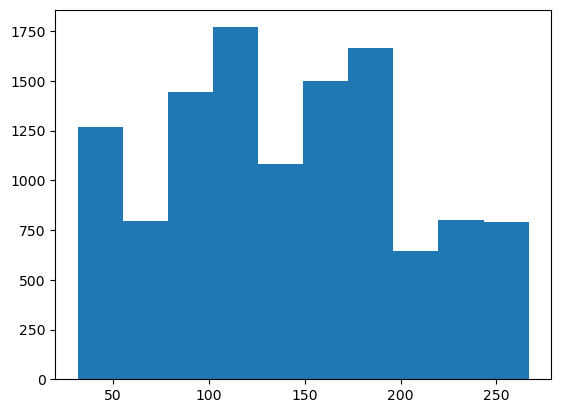

In [17]:
plt.hist(group2['Item_MRP'],label='not missing item weight')

(array([451., 262., 495., 602., 367., 508., 570., 228., 262., 271.]),
 array([ 32.0558 ,  55.53906,  79.02232, 102.50558, 125.98884, 149.4721 ,
        172.95536, 196.43862, 219.92188, 243.40514, 266.8884 ]),
 <BarContainer object of 10 artists>)

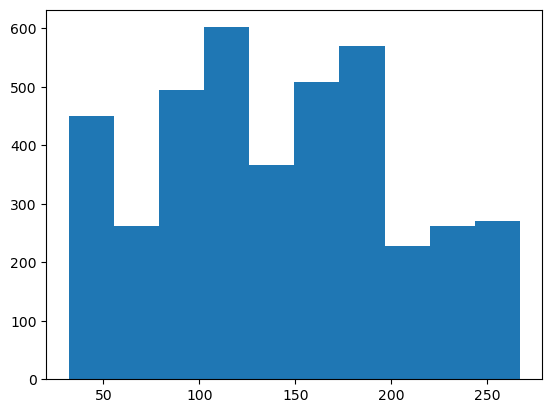

In [18]:
plt.hist(group3['Item_MRP'],label='Missing outlet_size')

(array([1086.,  681., 1256., 1537.,  952., 1308., 1441.,  544.,  703.,
         680.]),
 array([ 31.29   ,  54.84984,  78.40968, 101.96952, 125.52936, 149.0892 ,
        172.64904, 196.20888, 219.76872, 243.32856, 266.8884 ]),
 <BarContainer object of 10 artists>)

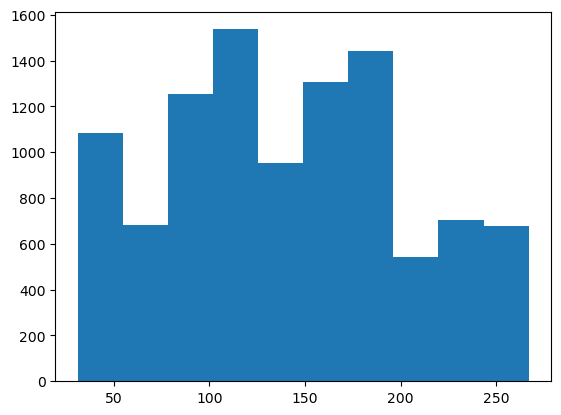

In [19]:
plt.hist(group4['Item_MRP'],label='Not Missing Outlet_Size')

We can ignore Item_MRP as it does not have any impact on the missing values

(array([1559.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         880.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

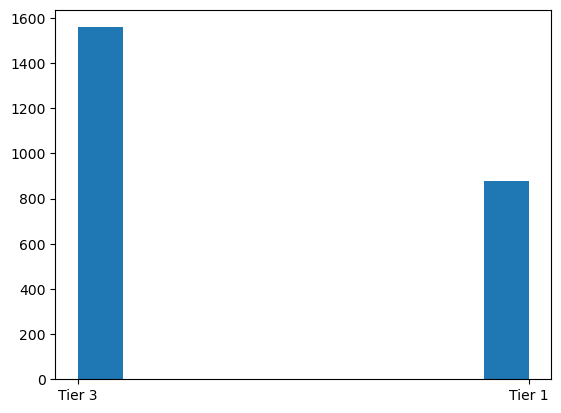

In [20]:
plt.hist(group1['Outlet_Location_Type'],label='Missing item weight')

(array([3100.,    0.,    0.,    0.,    0., 4024.,    0.,    0.,    0.,
        4641.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

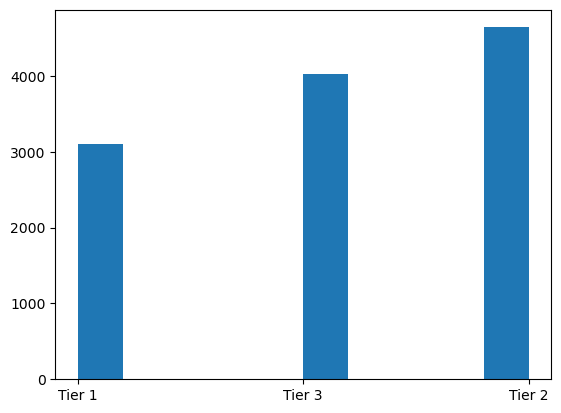

In [21]:
plt.hist(group2['Outlet_Location_Type'],label='Not Missing item weight')

(array([ 925.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3091.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

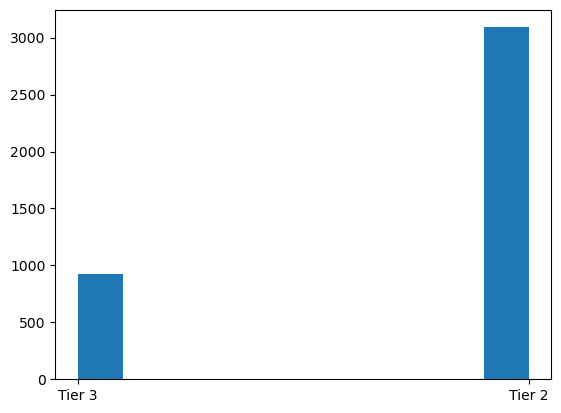

In [22]:
plt.hist(group3['Outlet_Location_Type'],label='Missing Oulet size')

(array([3980.,    0.,    0.,    0.,    0., 4658.,    0.,    0.,    0.,
        1550.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

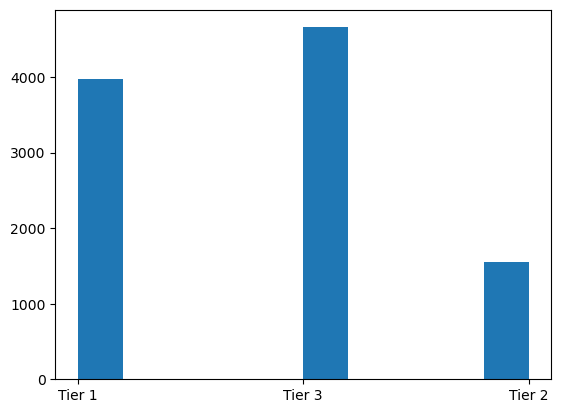

In [23]:
plt.hist(group4['Outlet_Location_Type'],label='not missing outlet size')

Data follows MAR (Missing At Random) as there is a correlation between missing data and some of the variables. There is a higher level of correlation between the missing values and the Item_Identifier and Outlet_Identifier

### Checking Item_Weight missing values relationship with Item_Identifier

In [24]:
#For Item_Weight
missing_data=original[original['Item_Weight'].isnull()].copy()
missing_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,LF,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,LF,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,REGULAR,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,LF,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,REGULAR,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


In [25]:
data=original.dropna().copy()

In [26]:
missing_identifier=missing_data['Item_Identifier'].unique()
missing_identifier

array(['FDP10', 'DRI11', 'FDW12', ..., 'FDC39', 'DRE03', 'FDN31'],
      dtype=object)

In [27]:
identifier=data['Item_Identifier'].unique()
identifier

array(['FDA15', 'DRC01', 'FDN15', ..., 'FDV36', 'FDT35', 'FDV27'],
      dtype=object)

In [28]:
missing_identifier=missing_identifier.sort()
identifier=identifier.sort()
print(missing_identifier==identifier)

True


Since all the identifiers that are missing values have at least one identifier with a non-null value, we can use these non-missing Item_Weight indentifiers to impute the value for missing Item_Weight rows.

In [29]:
data_imputed=original.copy()

In [30]:
for row in missing_data.itertuples():
    row=row._asdict()
    index=row['Index']
    data_imputed.loc[index,'Item_Weight']=data[data['Item_Identifier']==row['Item_Identifier']].iloc[0]['Item_Weight'].copy()

In [31]:
data_imputed.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Item_Weight has been sucessfully imputed. Now we try to deal with Outlet_Size

### Checking Outlet_Size missing values if a relationship exists

In [32]:
#For Outlet_Size
missing_data=data_imputed[data_imputed['Outlet_Size'].isnull()].copy()
missing_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,REGULAR,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,REGULAR,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,REGULAR,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,LF,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,REGULAR,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344


In [33]:
missing_identifier=missing_data['Outlet_Identifier'].unique()
missing_identifier

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [34]:
identifier=data_imputed.dropna()['Outlet_Identifier'].unique()
identifier

array(['OUT049', 'OUT018', 'OUT013', 'OUT027', 'OUT046', 'OUT035',
       'OUT019'], dtype=object)

There is no common identifiers we can use to impute the values.

In [35]:
data=data_imputed.dropna().copy()

In [36]:
missing_data[['Outlet_Type','Outlet_Location_Type']].value_counts()

Outlet_Type        Outlet_Location_Type
Supermarket Type1  Tier 2                  3091
Grocery Store      Tier 3                   925
dtype: int64

Now we are going to find the values for Outlet_Size for Outlet_Type = Supermarket Type1 and Outlet_Location_Type = Tier 2

In [37]:
supermarket_type1=data[data['Outlet_Type']=='Supermarket Type1']
supermarket_type1[supermarket_type1['Outlet_Location_Type']=='Tier 2'].Outlet_Size.value_counts()

Small    1550
Name: Outlet_Size, dtype: int64

In [38]:
value=supermarket_type1[supermarket_type1['Outlet_Location_Type']=='Tier 2'].Outlet_Size.unique()
value[0]

'Small'

It is seen that the outlet size for Supermarket Type1 and Tier 2 is 'Small'. So for missing Outlet_Size values having Supermarket Type1 and Tier 2, we are going to impute the value of 'Small'

In [39]:
for row in missing_data.itertuples():
    row=row._asdict()
    index = row['Index']
    if(row['Outlet_Location_Type']=='Tier 2' and row['Outlet_Type']=='Supermarket Type1'):
        data_imputed.loc[index,'Outlet_Size']=value[0]
        

In [40]:
data_imputed.isnull().sum()

Item_Identifier                0
Item_Weight                    0
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                  925
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

In [41]:
data_imputed[data_imputed['Outlet_Size'].isnull()].Outlet_Location_Type.value_counts()

Tier 3    925
Name: Outlet_Location_Type, dtype: int64

In [42]:
data_imputed[data_imputed['Outlet_Size'].isnull()].Outlet_Type.value_counts()

Grocery Store    925
Name: Outlet_Type, dtype: int64

In [43]:
data=data_imputed.dropna().copy()

In [44]:
data[data['Outlet_Location_Type']=='Tier 3'].Outlet_Type.value_counts()

Supermarket Type3    1559
Supermarket Type1    1553
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [45]:
missing_data=data_imputed[data_imputed['Outlet_Size'].isnull()]
missing_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,REGULAR,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
28,FDE51,5.925,REGULAR,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
30,FDV38,19.250,LF,0.170349,Dairy,55.7956,OUT010,1998,NaN,Tier 3,Grocery Store,163.7868
45,FDM39,6.420,LF,0.089499,Dairy,178.1002,OUT010,1998,NaN,Tier 3,Grocery Store,358.2004
65,FDC46,17.700,LF,0.195068,Snack Foods,185.4266,OUT010,1998,NaN,Tier 3,Grocery Store,184.4266


In [46]:
missing_data['Outlet_Identifier'].unique()

array(['OUT010'], dtype=object)

In [47]:
missing_data['Outlet_Establishment_Year'].unique()

array([1998])

In [48]:
missing_data['Outlet_Location_Type'].unique()

array(['Tier 3'], dtype=object)

In [49]:
missing_data['Outlet_Type'].unique()

array(['Grocery Store'], dtype=object)

Lets check if Grocery Store and other Outlet_Types are similar or not 

In [50]:
data[data['Outlet_Identifier']=='OUT010']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [51]:
data[data['Outlet_Establishment_Year']==1998]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [52]:
data[data['Outlet_Location_Type']=='Tier 3'].Outlet_Type.value_counts()

Supermarket Type3    1559
Supermarket Type1    1553
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [53]:
tier3=data[data['Outlet_Location_Type']=='Tier 3']

In [54]:
tier3['Outlet_Size'].value_counts()

Medium    3105
High      1553
Name: Outlet_Size, dtype: int64

In [55]:
data_imputed[data_imputed['Item_Identifier']==missing_data['Item_Identifier'].unique()[0]]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.2,REGULAR,0.000000,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.380000
1491,FDX07,19.2,REGULAR,0.022914,Fruits and Vegetables,181.195,OUT035,2004,Small,Tier 2,Supermarket Type1,2380.235000
2459,FDX07,19.2,REGULAR,0.022965,Fruits and Vegetables,181.695,OUT045,2002,Small,Tier 2,Supermarket Type1,2563.330000
3089,FDX07,19.2,REGULAR,0.000000,Fruits and Vegetables,184.595,OUT018,2009,Medium,Tier 3,Supermarket Type2,3844.995000
5906,FDX07,19.2,REGULAR,0.022954,Fruits and Vegetables,184.495,OUT049,1999,Medium,Tier 1,Supermarket Type1,4028.090000
7735,FDX07,19.2,REGULAR,0.022808,Fruits and Vegetables,183.495,OUT027,1985,Medium,Tier 3,Supermarket Type3,4577.375000
9054,FDX07,19.2,REGULAR,0.023048,Fruits and Vegetables,183.495,OUT017,2007,Small,Tier 2,Supermarket Type1,3046.591962
12074,FDX07,19.2,REGULAR,0.022919,Fruits and Vegetables,183.995,OUT046,1997,Small,Tier 1,Supermarket Type1,2587.117123
12561,FDX07,19.2,REGULAR,0.022900,Fruits and Vegetables,185.095,OUT013,1987,High,Tier 3,Supermarket Type1,3330.027700


In [56]:
tier3[tier3['Outlet_Size']=='Medium'].Outlet_Type.value_counts()

Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64

In [57]:
tier3[tier3['Outlet_Size']=='High'].Outlet_Type.value_counts()

Supermarket Type1    1553
Name: Outlet_Type, dtype: int64

(array([4655.,    0.,    0.,    0.,    0., 1553.,    0.,    0.,    0.,
        7071.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

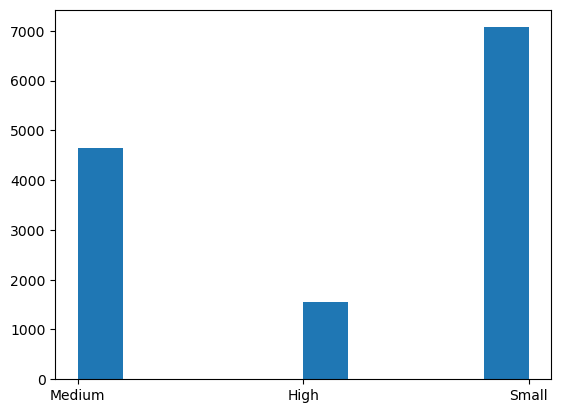

In [58]:
plt.hist(data['Outlet_Size'])

(array([4655.,    0.,    0.,    0.,    0., 1553.,    0.,    0.,    0.,
        3980.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

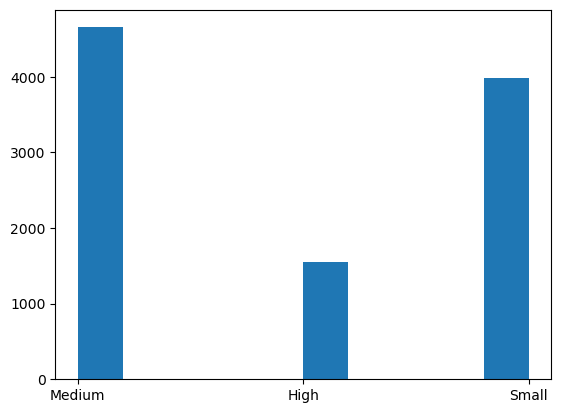

In [59]:
plt.hist(original['Outlet_Size'].dropna())

Based on the comparison of distributions we are going to assume that a Tier 3 Grocery Store has an Outlet Size of Medium and compare the distributions again.

In [60]:
for row in missing_data.itertuples():
    row=row._asdict()
    index=row['Index']
    data_imputed.loc[index,'Outlet_Size']='Medium'

(array([5580.,    0.,    0.,    0.,    0., 1553.,    0.,    0.,    0.,
        7071.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

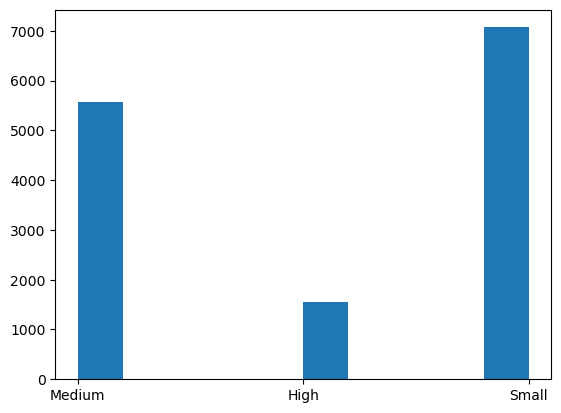

In [61]:
plt.hist(data_imputed['Outlet_Size'])

In [62]:
data_imputed.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

The distributions are different and since we have no source of information to accurately impute the values for Missing Values in Outlet_Size, We can remove the column from the dataset as it has a correlation with Outlet_Identifier, Outlet_Location_Type,Outlet_Type and Outlet_Establishment_Year and will have some information regarding the Outlet_Size in these variables. So we can remove the Variable to prevent any risk of bias caused by imputing values based on assumptions.

In [63]:
data_imputed=data_imputed.drop(['Outlet_Size'],axis=1)
data_imputed.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,LF,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,REGULAR,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,LF,0.016760,Meat,141.6180,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,REGULAR,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,LF,0.000000,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052


## Final Datasets

In [64]:
original_na_dropped=original.dropna().copy()
original_imputed=data_imputed.copy()

In [65]:
original_na_dropped.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,LF,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,REGULAR,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,LF,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,NCD19,8.930,LF,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,REGULAR,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,REGULAR,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
10,FDY07,11.800,LF,0.000000,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
11,FDA03,18.500,REGULAR,0.045464,Dairy,144.1102,OUT046,1997,Small,Tier 1,Supermarket Type1,2187.1530
12,FDX32,15.100,REGULAR,0.100014,Fruits and Vegetables,145.4786,OUT049,1999,Medium,Tier 1,Supermarket Type1,1589.2646
13,FDS46,17.600,REGULAR,0.047257,Snack Foods,119.6782,OUT046,1997,Small,Tier 1,Supermarket Type1,2145.2076


In [66]:
original_imputed.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,LF,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,REGULAR,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,LF,0.016760,Meat,141.6180,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,REGULAR,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,LF,0.000000,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,REGULAR,0.000000,Baking Goods,51.4008,OUT018,2009,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,REGULAR,0.012741,Snack Foods,57.6588,OUT013,1987,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,LF,0.127470,Snack Foods,107.7622,OUT027,1985,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,REGULAR,0.016687,Frozen Foods,96.9726,OUT045,2002,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,REGULAR,0.094450,Frozen Foods,187.8214,OUT017,2007,Tier 2,Supermarket Type1,4710.5350


In [67]:
original.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,LF,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,REGULAR,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,LF,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,REGULAR,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,LF,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,REGULAR,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,REGULAR,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,LF,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,REGULAR,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,REGULAR,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


## Final Conclusion

We are going to store the final imputed dataset in an excel file named 'final_dataset'

In [68]:
with pd.ExcelWriter('/Users/omarhassan/Documents/GitHub/BigMart-Analysis/Dataset/datasets.xlsx') as writer:
    original.to_excel(writer,sheet_name='Original_Dataset',index=False)
    data.to_excel(writer,sheet_name='Original_NA_Dropped',index=False)
    data_imputed.to_excel(writer,sheet_name='Original_Imputed',index=False)